In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random

from scipy.integrate import odeint


In [2]:
class Network:
    def __init__(self, radius):
        self.radius = radius

    def hexagon_mask(self, x, y):
        """
        Return True if the point (x, y) is within a hexagon of given radius
        """
        return np.abs(x) <= self.radius and np.abs(y) <= self.radius and np.abs(x + y) <= self.radius
    
    def create_hexagonal_network(self):
        """
        Return the hexagonal undirected network of given radius with triangular lattice
        """
        G = nx.Graph()
        # Create the triangular lattice
        for x in range(-self.radius, self.radius + 1):
            for y in range(-self.radius, self.radius + 1):
                if self.hexagon_mask(x, y):
                    # Add the node
                    G.add_node((x, y))
                    # Add edges to neighbors
                    neighbors = [(x + 1, y), (x, y + 1), (x - 1, y + 1)]
                    for nx_, ny_ in neighbors:
                        if self.hexagon_mask(nx_, ny_):
                            G.add_edge((x, y), (nx_, ny_))
                            #G.add_edge((nx_, ny_), (x, y))
        return G
    

    def cuadratic_mask(self, x, y):
        """
        Return True if the point (x, y) is within a cuadratic of given radius
        """
        return np.abs(x) <= self.radius and np.abs(y) <= self.radius 

    def create_cuadratic_network(self):
        """
        Return the cuadratic undirected network of given radius
        """
        G = nx.Graph()
        # Create the cuadratic lattice
        for x in range(-self.radius, self.radius+1):
            for y in range(-self.radius, self.radius+1):
                if self.cuadratic_mask(x, y, self.radius):
                    # Add the node
                    G.add_node((x, y))
                    # Add edges to neighbors
                    neighbors = [(x + 1, y), (x, y + 1)]
                    for nx_, ny_ in neighbors:
                        if self.cuadratic_mask(nx_, ny_, self.radius):
                            G.add_edge((x, y), (nx_, ny_))
        return G
    
    """
    def plot_network(self):
        #Plot the hexagonal network
        pos = {node: (node[0] + 0.5 * node[1], node[1] * np.sqrt(3)/2) for node in self.G.nodes()}
        plt.figure(figsize=(6, 5))
        nx.draw(self.G, pos, node_size=100, node_color='lightblue', edge_color='gray', with_labels=True)
        plt.title(f'Radius={self.radius}')
        plt.show()
    """

In [3]:
"""
class CityTrafficSimulation(Network):
    def __init__(self, radius, n_users, network = "hexagonal"):
        self.radius = radius
        self.n_users = n_users
        if network == "quadratic":
            self.G = self.create_cuadratic_network()
        elif network == "hexagonal":
            self.G =self.create_hexagonal_network()
"""

class CityTrafficSimulation:
    def __init__(self, n_users, G):
        self.n_users = n_users
        self.G = G

    def generate_paths(self, trips_probab_dist):
        """
        Generate random O-D points and connect them by unweighted (all links have the same weight) shortest paths.
        The output is the paths of edges.
        """
        paths = []
        trips = trips_probab_dist
        nod_idx_dict = {nod:idx for idx, nod in enumerate(self.G.nodes())}
        #print(nod_idx_dict)
        OD_matrix = np.zeros((len(nod_idx_dict), len(nod_idx_dict)))
        total_prob = sum(trip[2] for trip in trips)
        trips = [(o, d, p / total_prob) for o, d, p in trips]  # Normalize probabilities
        origins, destinations, probabilities = zip(*trips)
        chosen_trips = random.choices(list(zip(origins, destinations)), weights=probabilities, k=self.n_users)
        for trip in chosen_trips:
            OD_matrix[nod_idx_dict[trip[0]], nod_idx_dict[trip[1]]] += 1
            #OD_matrix = pd.DataFrame(OD_matrix)
            path_of_nodes = nx.dijkstra_path(self.G, trip[0], trip[1])
            path_of_edges = [(path_of_nodes[edge], path_of_nodes[edge+1]) for edge in range(len(path_of_nodes)-1)]
            paths.append(path_of_edges)
        return paths, OD_matrix

In [4]:
class Congestion:
    def __init__(self, paths, edge_capacity, t_block):
        self.paths = paths
        self.edge_capacity = edge_capacity
        self.t_block = t_block
        #seld.edge_counts = self.count_transport_edge()
        self.congestion_ratio = self.congestion_points()

    def count_transport_edge(self):
        """
        Count the number of users passing through an edge. Return a tuple with the edge (key) and number (value)
        """
        tuple_counts = {}

        for i, path1 in enumerate(self.paths):
            for edge in path1:
                if edge not in tuple_counts:
                    tuple_counts[edge] = 1
                for j, path2 in enumerate(self.paths):
                    if i != j:
                        tuple_counts[edge] += path2.count(edge)
        return tuple_counts
    
    def congestion_points(self):
        """
        Determine the congestion level of each edge using the volume-over-capacity ratio 
        """ 
        # Count the number of users passing through each edge
        tuple_counts = self.count_transport_edge()

        # Determine the congestion edges
        congestion_ratios = {}
        for i, j in enumerate(tuple_counts):
            congestion_ratio = list(tuple_counts.values())[i] / self.edge_capacity
            congestion_ratios[j] = congestion_ratio
        return congestion_ratios
    
    def baseline_CT(self):
        """
        COMPUTE THE BASELINE COMMUTING TIME
        Considering that the velocity decreases linearly until reach the congestion
        """
        baselines = []
        for path in self.paths:
            baseline = len(path) * self.t_block #t_block units (minutes)
            baselines.append(baseline)
        return baselines #minutes

    def direct_CT(self, alpha=0.15, beta=4):
        """
        COMPUTE THE DIRECT COMMUTING TIME
        Using the BPR function, the output units depend on t_block unit (preferably in minutes)
        """ 
        #congestion_points = [key for key, value in self.congestion_ratio.items() if value > 0.8]
        direct = []
        for path in self.paths:
            c = 0
            for edge in path:
                c += alpha * self.t_block * (self.congestion_ratio[edge]**beta) #minutes
            direct.append(c) #minutes
        return direct #direct_cost in minutes

    def indirect_CT(self, other_method_paths, penalty=0.1):
        """
        COMPUTE THE INDIRECT COMMUTING TIME
        """
        indirect = []
        for tuple in other_method_paths:
            c = 0
            for edge in tuple:
                if (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.6):
                    c += 0 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.7):
                    c += 1 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.8):
                    c += 2 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 0.9):
                    c += 3 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] < 1.0):
                    c += 4 * penalty #sec
                elif (edge in list(self.congestion_ratio.keys())) and (self.congestion_ratio[edge] > 1.0):
                    c += 5 * penalty #sec
                else:
                    continue
            indirect.append(c/60)
        return indirect #minutes

In [5]:
class ModalShareDistribution:
    def __init__(self, x, N, B_0, M):
        self.x = x
        self.N = N
        self.B_0 = B_0
        self.M = M

    def find_minimum_mean_commuting_time(self):
        D = self.M[0][0] - self.M[0][1] - self.M[1][0] + self.M[1][1]
        E = self.B_0[0] - self.B_0[1] + self.N*self.M[0][1] + self.N*self.M[1][0] - 2*self.N*self.M[1][1]
        F = self.N*self.B_0[1] + (self.N**2)*self.M[1][1]
        r_star = -E/(2*D)
        return [r_star, self.N-r_star]    

    def commuting_time_vec(self, x):
        """
        Compute the commuting time of the system. Output: a vector
        """
        return (self.B_0 + (self.M @ x))
    
    def mean_commuting_time(self, x):
        """
        Compute the average commuting time. Output: a scalar
        """
        mu = (1/self.N) * (np.dot(x.T, self.B_0) + np.dot(x.T, np.dot(self.M, x)))
        return mu

    def replication_eq(self, x, t, rho):
        """
        Find the rate of change (derivative w.r.t. time) of a modal share. 
        """
        x = (x / np.sum(x)) * self.N
        C = self.commuting_time_vec(x)
        mu = (1 / self.N) * np.dot(C, x)
        x_dot = rho * x * (mu - C)
        return x_dot
    
    def solve_replication_eq(self, x, t, rho):
        """
        Implement the replicator dynamics
        """
        xs = odeint(func = self.replication_eq, y0 = x, t = t, args = (rho, ))
        return xs

In [6]:
def prob_distr_OD_relation(G, gravity = True):
    """
    Gives the probability of two points, origin and destination, being connected. 
    A bigger probability means more attraction between the points.
    The probability could follow the gravity or model: 'gravity = True'
    Or a random distribution where all the points have the same probability: 'gravity = False'
    """
    nodes = list(G.nodes())
    attractiveness = {node: random.uniform(1, 10) for node in nodes}  # Random attractiveness factor
    trips = []
    for origin in nodes:
        for destination in nodes:
            if origin != destination:
                if gravity:
                    distance = nx.shortest_path_length(G, origin, destination)
                    probability = (attractiveness[origin] * attractiveness[destination]) / (distance ** 2 + 1e-5)
                    trips.append((origin, destination, probability))
                else:
                    trips.append((origin, destination, 1))
    return trips

def convert_mins_to_days(x):
    return x/(60*24)


In [7]:
average_speed_bike = 12 #km/h
average_speed_car = 30 #km/h
block_length = 0.1 #km

t_block_car = (block_length / average_speed_car) * 60 #minutes
t_block_bike = (block_length / average_speed_bike) * 60 #minutes



car_length = 0.005 #km
distance_bt_cars = 0.003 #km
bike_length = 0.002 #km
distance_bt_bikes = 0.002 #km

edge_capacity_cars = block_length / (car_length + distance_bt_cars) #dimensionless
edge_capacity_bkes = block_length / (bike_length + distance_bt_bikes) #dimensionless

edge_capacity_cars_time = edge_capacity_cars * (60)  # in one hour
edge_capacity_bkes_time = edge_capacity_bkes * (60) # in one hour

In [8]:
radius = 25
network = Network(radius)
G = network.create_hexagonal_network()

average_shortest_path_L = nx.average_shortest_path_length(G)
diameter_network = nx.diameter(G)
print("Length (diameter) of the city is", diameter_network*block_length, "km, the area is", np.round(((3*np.sqrt(3))/(2))*((radius*block_length)**2), 2), "km^2, and the number of users is", 2, ".")
print('Average shortest path length is', average_shortest_path_L*block_length,'km.')
print()
print('Baseline cost in minutes (path-independent):\t', [average_shortest_path_L*t_block_bike, average_shortest_path_L*t_block_car])

Length (diameter) of the city is 5.0 km, the area is 16.24 km^2, and the number of users is 2 .
Average shortest path length is 2.3237109174782162 km.

Baseline cost in minutes (path-independent):	 [11.618554587391081, 4.6474218349564325]


In [9]:
OD_relation = prob_distr_OD_relation(G, False)

n_users = {'bikes':1700, 'cars':2300}
N = sum(n_users.values())

bike_edges_paths, OD_bike = CityTrafficSimulation(n_users['bikes'], G).generate_paths(OD_relation)
car_edges_paths, OD_car = CityTrafficSimulation(n_users['cars'], G).generate_paths(OD_relation)

In [10]:
timesteps = 150
rho = 0.6

dynamics_vector = [[n_users['bikes'], n_users['cars']]]
C_vec_0 = []
mu_vec_0 = []
mu_vec_optimal_0 = []
for i in range(timesteps):
    C_bike = Congestion(bike_edges_paths, edge_capacity_bkes_time, t_block_bike)
    C_car = Congestion(car_edges_paths, edge_capacity_cars_time, t_block_car)
    bike_congested_time = C_bike.direct_CT(alpha=0.15, beta=4)
    car_congested_time = C_car.direct_CT(alpha=0.15, beta=4)
    baseline_cost = [np.mean(C_bike.baseline_CT()), np.mean(C_car.baseline_CT())]
    direct_cost = [np.mean(bike_congested_time), np.mean(car_congested_time)]
    indirect_cost = [[0, np.mean(C_bike.indirect_CT(car_edges_paths))], [np.mean(C_car.indirect_CT(bike_edges_paths)), 0]]

    x = np.array([n_users['bikes'], n_users['cars']])
    N = sum(n_users.values())
    B_0 = convert_mins_to_days(np.array(baseline_cost))    #days
    D_0 = convert_mins_to_days(np.diag(direct_cost))       #days
    I_0 = convert_mins_to_days(np.array(indirect_cost))    #days
    M = D_0 + I_0

    #print(N, B_0, M)

    replicator_dynamics = ModalShareDistribution(x, N, B_0, M)
    C_0 = replicator_dynamics.commuting_time_vec(x)
    C_vec_0.append(C_0)
    mu_0 = replicator_dynamics.mean_commuting_time(x)
    mu_vec_0.append(mu_0)
    optimal_point = replicator_dynamics.find_minimum_mean_commuting_time()
    #print(optimal_point)
    mu_vec_optimal_0.append(replicator_dynamics.mean_commuting_time(np.array(optimal_point)))

    print(i, n_users, optimal_point)

    timepoints = np.arange(0, 2)
    x_vec = replicator_dynamics.solve_replication_eq(x, timepoints, rho)
    dynamics_vector.append(list(x_vec[-1]))


    bike_difference = int(int(np.round(x_vec[-1][0])) - n_users['bikes']) 
    ## bikes population are increasing --> move paths from cars to bikes
    if bike_difference > 0:
        car_congested_times = sorted(list(set(car_congested_time)), key = lambda x:float(x), reverse=True)
        car_path_congested_idx = []
        for i in car_congested_times:
            car_path_congested_idx_i = [index for index, value in enumerate(car_congested_time) if value == i]
            car_path_congested_idx += car_path_congested_idx_i
            if len(car_path_congested_idx) >= bike_difference:
                selected_paths_idx = random.sample(car_path_congested_idx, bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            bike_edges_paths.append(car_edges_paths[sel_pth])
            car_edges_paths.remove(car_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}        
    ## no population increasing
    elif bike_difference == 0:
        bike_edges_paths = bike_edges_paths
        car_edges_paths = car_edges_paths
    ## cars population are increasing --> more paths from bikes to cars
    else:
        bike_congested_times = sorted(set(bike_congested_time), key = lambda x:float(x), reverse=True)
        bike_path_congested_idx = []
        for i in bike_congested_times:
            bike_path_congested_idx_i = [index for index, value in enumerate(bike_congested_time) if value == i]
            bike_path_congested_idx += bike_path_congested_idx_i
            if len(bike_path_congested_idx) >= -bike_difference:
                selected_paths_idx = random.sample(bike_path_congested_idx, -bike_difference)
                selected_paths_idx.sort(reverse=True)
                break        
        for sel_pth in selected_paths_idx:
            car_edges_paths.append(bike_edges_paths[sel_pth])
            bike_edges_paths.remove(bike_edges_paths[sel_pth])
        n_users = {'bikes':int(np.round(x_vec[-1][0])), 'cars':int(np.round(x_vec[-1][1]))}

0 {'bikes': 1700, 'cars': 2300} [-1239.0945776106419, 5239.094577610642]
1 {'bikes': 1698, 'cars': 2302} [-1233.9415995418567, 5233.941599541857]
2 {'bikes': 1696, 'cars': 2304} [-1119.25734260122, 5119.25734260122]
3 {'bikes': 1694, 'cars': 2306} [-864.2853440288903, 4864.28534402889]
4 {'bikes': 1692, 'cars': 2308} [-844.3639327523123, 4844.363932752312]
5 {'bikes': 1690, 'cars': 2310} [-762.0876170748004, 4762.087617074801]
6 {'bikes': 1688, 'cars': 2312} [-491.6098843535417, 4491.609884353542]
7 {'bikes': 1686, 'cars': 2314} [-492.19758082898295, 4492.197580828983]
8 {'bikes': 1684, 'cars': 2316} [-493.7378563120465, 4493.7378563120465]
9 {'bikes': 1682, 'cars': 2318} [-449.57975307797324, 4449.579753077973]
10 {'bikes': 1680, 'cars': 2320} [-363.3588335576677, 4363.358833557668]
11 {'bikes': 1678, 'cars': 2322} [-343.18826694168956, 4343.18826694169]
12 {'bikes': 1676, 'cars': 2324} [-336.330811742092, 4336.330811742092]
13 {'bikes': 1674, 'cars': 2326} [-163.313029557429, 4163.31

KeyboardInterrupt: 

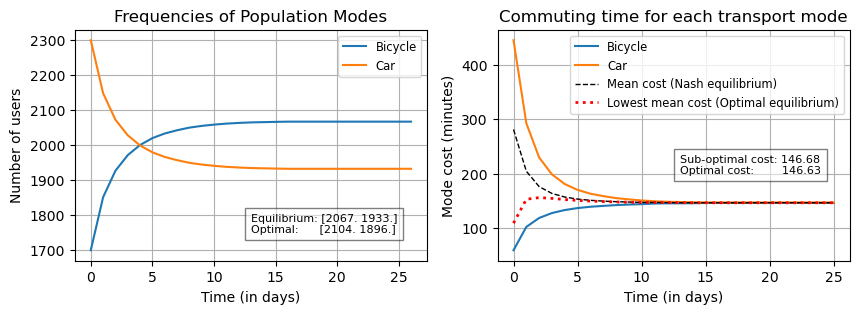

In [18]:
# alpha=0.1, beta=1

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(13, 1750, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].set_title("Commuting time for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
#ax[1].set_ylim(10, 25)
ax[1].text(13, 200, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

#plt.savefig('dynamics_triangularGrid_random_3000user.png')

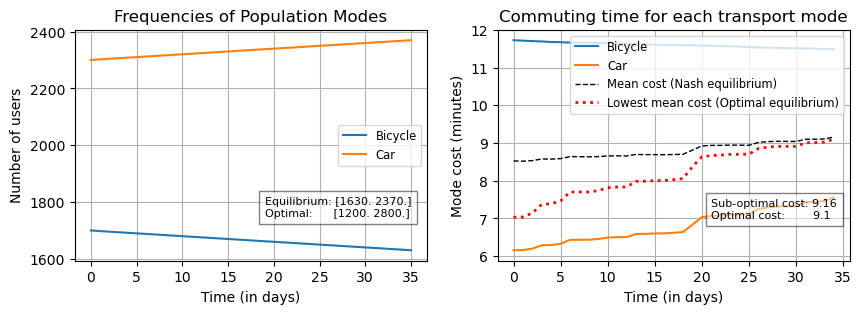

In [16]:
# alpha=0.15, beta=4

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
#fig.suptitle('Random paths generation in triangular grid')
ax[0].plot(dynamics_vector)
ax[0].set_xlabel("Time (in days)")
ax[0].set_ylabel("Number of users")
ax[0].set_title("Frequencies of Population Modes")
ax[0].legend(['Bicycle', 'Car'], loc='best', fontsize='small')
ax[0].text(19, 1750, f'Equilibrium: {np.round(dynamics_vector[-1], 0)}\nOptimal:      {np.round(optimal_point, 0)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[0].grid()
ax[1].plot([i*24*60 for i in C_vec_0])
ax[1].plot([i*24*60 for i in mu_vec_0], color='black', linestyle='dashed', linewidth=1)
ax[1].plot([i*24*60 for i in mu_vec_optimal_0], color='red', linestyle='dotted', linewidth=2)
ax[1].set_xlabel("Time (in days)")
ax[1].set_ylabel("Mode cost (minutes)")
ax[1].set_title("Commuting time for each transport mode")
ax[1].legend(['Bicycle', 'Car', 'Mean cost (Nash equilibrium)', 'Lowest mean cost (Optimal equilibrium)'], loc='best', fontsize='small')
#ax[1].set_ylim(10, 25)
ax[1].text(21, 7, f'Sub-optimal cost: {np.round(mu_vec_0[-1]*24*60, 2)}\nOptimal cost:        {np.round(mu_vec_optimal_0[-1]*24*60, 2)}', fontsize = 8, bbox = dict(facecolor = 'white', alpha = 0.5))
ax[1].grid()

#plt.savefig('dynamics_triangularGrid_random_3000user.png')

**Vectorial analysis of the OD matrix**

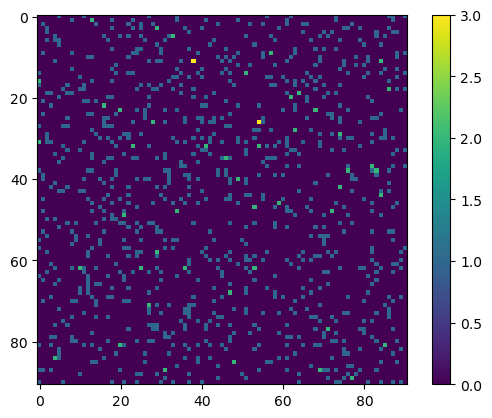

In [17]:
# OD matrix: randomly generated
trafficSimulation = CityTrafficSimulation(radius=5, n_users=1000)
bike_edges_paths, OD_bike = trafficSimulation.generate_paths()
net = trafficSimulation.create_hexagonal_network()

plt.imshow(OD_bike)
plt.colorbar()


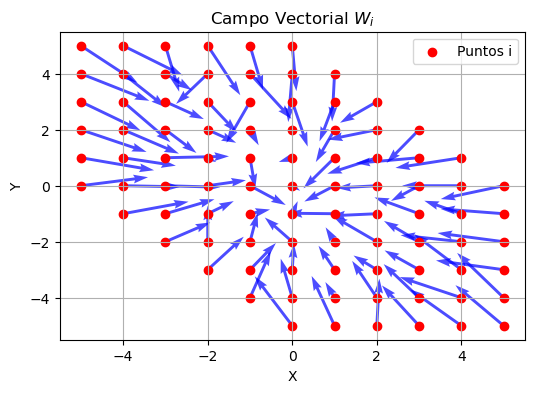

In [18]:
N = OD_bike.shape[0]
positions = np.array(net.nodes())

T_vectors = np.zeros((N, 2))
W_vectors = np.zeros((N, 2))
#print(positions)
for i in range(N):
    m_i = np.sum(OD_bike[i, :])
    #print(m_i)
    if m_i == 0:
        continue

    for j in range(N):
        if i != j:
            direction = positions[j] - positions[i]
            u_ij = direction / np.linalg.norm(direction)

            T_vectors[i] += OD_bike[i, j] * u_ij

    W_vectors[i] = T_vectors[i] / m_i
    
# Graficar el campo vectorial
plt.figure(figsize=(6, 4))
plt.quiver(positions[:, 0], positions[:, 1], W_vectors[:, 0], W_vectors[:, 1],
           angles='xy', scale_units='xy', scale=0.5, color='b', alpha=0.7)
plt.scatter(positions[:, 0], positions[:, 1], color='r', label='Puntos i')
#plt.xlim(0, 10)
#plt.ylim(0, 10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Campo Vectorial $W_i$")
plt.legend()
plt.grid()
plt.show()

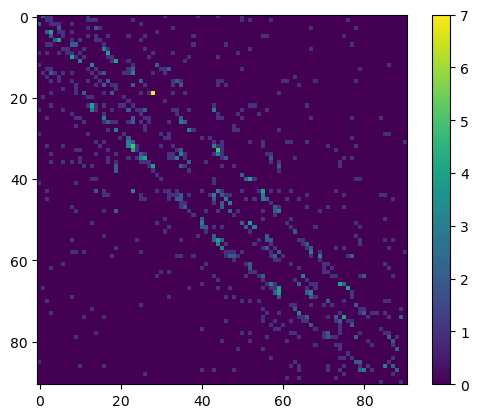

In [20]:
# OD matrix: generated by gravity model
trafficSimulation = CityTrafficSimulationGravity(radius=5, n_users=1000)
bike_edges_paths, OD_bike = trafficSimulation.generate_paths()
net = trafficSimulation.create_hexagonal_network()

plt.imshow(OD_bike)
plt.colorbar()

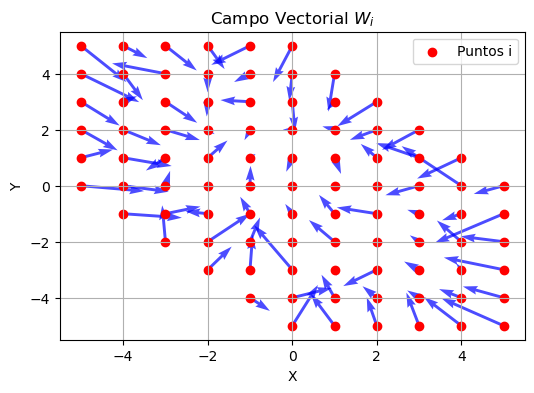

In [21]:
N = OD_bike.shape[0]
positions = np.array(net.nodes())

T_vectors = np.zeros((N, 2))
W_vectors = np.zeros((N, 2))
#print(positions)
for i in range(N):
    m_i = np.sum(OD_bike[i, :])
    #print(m_i)
    if m_i == 0:
        continue

    for j in range(N):
        if i != j:
            direction = positions[j] - positions[i]
            u_ij = direction / np.linalg.norm(direction)

            T_vectors[i] += OD_bike[i, j] * u_ij

    W_vectors[i] = T_vectors[i] / m_i
    
# Graficar el campo vectorial
plt.figure(figsize=(6, 4))
plt.quiver(positions[:, 0], positions[:, 1], W_vectors[:, 0], W_vectors[:, 1],
           angles='xy', scale_units='xy', scale=0.5, color='b', alpha=0.7)
plt.scatter(positions[:, 0], positions[:, 1], color='r', label='Puntos i')
#plt.xlim(0, 10)
#plt.ylim(0, 10)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Campo Vectorial $W_i$")
plt.legend()
plt.grid()
plt.show()